# Robot de Limpieza Reactivo
Este modelo estudia las estadísticas de un robot de limpieza reactivo, donde se recopila la siguiente información:
* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).* Porcentaje de celdas limpias después del termino de la simulación.
* 
Número de movimientos realizados por todos los agentes.

## Datos proporcionados
* Habitación de MxN espacios
* Número de agentes
* Porcentaje de celdas inicialmente sucias
* Tiempo máximo de ejecución

## Reglas
Las reglas del modelo son:
* Inicializa las celdas sucias (ubicaciones aleatorias).* Todos los agentes empiezan en la celda [1,1].* En cada paso de tiempo:    * Si la celda está sucia, entonces aspira.
    * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda)
    * Se ejecuta el tiempo máximo estable

Analiza cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados.

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [1]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import ContinuousSpace
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

import numpy as np
import pandas as pd

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
class VacuumAgent(Agent):
    def __init__(self, id, model, x, y):
        super().__init__(id, model)
        self.x = x
        self.y = y
        self.position = np.array((x, y))
        self.movements = 0

    def step(self):
        self.movements += 1

In [3]:
def get_vacuums(model):
    return np.asarray([agent.position for agent in model.schedule.agents])

In [4]:
class VacuumModel(Model):
    def __init__(self, num_agents, width, height):
        self.schedule = SimultaneousActivation(self)
        self.grid = ContinuousSpace(width, height, torus = True)
        self.datacollector = DataCollector(model_reporters={"Vacuums": get_vacuums})

        for i in range(num_agents):
            x = 1
            y = 1
            agent = VacuumAgent(i, self, x, y)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
WIDTH = 100
HEIGHT = 100
NUM_VACUUMS = 2
MAX_ITERATIONS = 10

model = VacuumModel(NUM_VACUUMS, WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
    model.step()

In [7]:
all_positions = model.datacollector.get_model_vars_dataframe()

C:\Users\sgarn\AppData\Local\Temp\ipykernel_21128\2552971184.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
C:\Users\sgarn\AppData\Local\Temp\ipykernel_21128\2552971184.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])


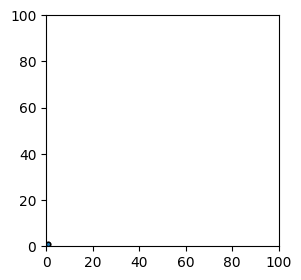

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
ax.axis([0, WIDTH, 0, HEIGHT])

def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])
    return scatter

anim = animation.FuncAnimation(fig, animate, frames = MAX_ITERATIONS)

In [9]:
anim

C:\Users\sgarn\AppData\Local\Temp\ipykernel_21128\2552971184.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])
